# DistilBERT fine tuning for tweet role classification (Social DL)

This notebook fine tunes a pretrained transformer model on the **Data Challenge** tweets.  

The goal is to predict whether a user is an **Influencer (1)** or an **Observer (0)** from the text of a single tweet.

Instead of using our own transformer, we use a **pretrained HuggingFace model** (for example DistilBERT or RoBERTa) and fine tune it for binary tweet classification.

In [1]:
# Standard libraries
import os
import json
import re
import random
from pathlib import Path

# Numerical and data handling
import numpy as np
import pandas as pd
from pandas import json_normalize

# Scikit learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# PyTorch core
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# HuggingFace Transformers
from transformers import AutoTokenizer, AutoModel
from transformers import get_linear_schedule_with_warmup

# Progress bar
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt

# Make plots appear inline in the notebook
%matplotlib inline

In [2]:
# We are in social-dl/notebooks/, so the root is one level up
ROOT_DIR = Path("..").resolve()

# Data directory (where train.jsonl and kaggle_test.jsonl live)
DATA_DIR = ROOT_DIR / "data"

# Output directory for this experiment
OUTPUT_DIR = ROOT_DIR / "outputs" / "distilbert"

# Create output directory if it does not exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Repository root:", ROOT_DIR)
print("Data directory  :", DATA_DIR)
print("Output directory:", OUTPUT_DIR)

# Device selection
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
    print(f"Using CUDA GPU: {device_name}")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    # For Apple Silicon users
    device = torch.device("mps")
    print("Using Apple Silicon MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Final device object:", device)

Repository root: /Users/zeen/Projects/social-dl
Data directory  : /Users/zeen/Projects/social-dl/data
Output directory: /Users/zeen/Projects/social-dl/outputs/distilbert
Using Apple Silicon MPS device
Final device object: mps


In [3]:
SEED = 42

def set_seed(seed: int = 42):
    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Global seed set to {seed}")

set_seed(SEED)

Global seed set to 42


## 1. Load and inspect the data

In this section we:

1. Load the challenge data from `train.jsonl` and `kaggle_test.jsonl`.
2. Flatten nested tweet JSON using `pandas.json_normalize`.
3. Recreate the `full_text` field:
   - Default to `text`.
   - If available, use `extended_tweet.full_text`.
4. Separate features and labels for training.
5. Extract `challenge_id` for Kaggle submission.
6. Do a quick sanity check and basic EDA to understand label balance and tweet lengths.

In [4]:
# Paths to the raw JSONL files
train_path = DATA_DIR / "train.jsonl"
kaggle_test_path = DATA_DIR / "kaggle_test.jsonl"

print("Train path      :", train_path)
print("Kaggle test path:", kaggle_test_path)

# Load the training data (one JSON object per line)
train_data_raw = pd.read_json(train_path, lines=True)
print("Raw train_data_raw shape:", train_data_raw.shape)

# Flatten nested tweet JSON into columns
train_data = json_normalize(train_data_raw.to_dict(orient="records"))
print("Flattened train_data shape:", train_data.shape)

# Load the Kaggle test data
kaggle_data_raw = pd.read_json(kaggle_test_path, lines=True)
print("Raw kaggle_data_raw shape:", kaggle_data_raw.shape)

# Flatten nested tweet JSON into columns
kaggle_data = json_normalize(kaggle_data_raw.to_dict(orient="records"))
print("Flattened kaggle_data shape:", kaggle_data.shape)

Train path      : /Users/zeen/Projects/social-dl/data/train.jsonl
Kaggle test path: /Users/zeen/Projects/social-dl/data/kaggle_test.jsonl
Raw train_data_raw shape: (154914, 37)
Flattened train_data shape: (154914, 193)
Raw kaggle_data_raw shape: (103380, 35)
Flattened kaggle_data shape: (103380, 191)


In [5]:
print("\n Sample train columns:")
print(train_data.columns[:30])

print("\nSample kaggle columns:")
print(kaggle_data.columns[:30])


 Sample train columns:
Index(['in_reply_to_status_id_str', 'in_reply_to_status_id', 'created_at',
       'in_reply_to_user_id_str', 'source', 'quoted_status_id',
       'retweet_count', 'retweeted', 'geo', 'filter_level',
       'in_reply_to_screen_name', 'is_quote_status', 'id_str',
       'in_reply_to_user_id', 'favorite_count', 'text', 'place', 'lang',
       'quote_count', 'favorited', 'coordinates', 'truncated', 'timestamp_ms',
       'reply_count', 'quoted_status_id_str', 'contributors', 'challenge_id',
       'label', 'extended_tweet', 'display_text_range'],
      dtype='object')

Sample kaggle columns:
Index(['in_reply_to_status_id_str', 'in_reply_to_status_id', 'created_at',
       'in_reply_to_user_id_str', 'source', 'retweet_count', 'retweeted',
       'geo', 'filter_level', 'in_reply_to_screen_name', 'is_quote_status',
       'id_str', 'in_reply_to_user_id', 'favorite_count', 'text', 'place',
       'lang', 'quote_count', 'favorited', 'possibly_sensitive', 'coordinates',
 

In [6]:
# Training features (everything except label)
X_train_raw = train_data.drop("label", axis=1)
# Training labels
y_train = train_data["label"]

# Kaggle features: copy the flattened dataframe
X_kaggle_raw = kaggle_data.copy()

print("X_train_raw shape :", X_train_raw.shape)
print("y_train shape     :", y_train.shape)
print("X_kaggle_raw shape:", X_kaggle_raw.shape)

# Peek at labels to ensure they look correct (0/1)
print("\nLabel values (first 30):")
print(y_train.head(30).tolist())

X_train_raw shape : (154914, 192)
y_train shape     : (154914,)
X_kaggle_raw shape: (103380, 191)

Label values (first 30):
[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]


In [7]:
def extract_full_text(tweet_row: pd.Series) -> str:
    """
    Given a flattened tweet row, return the 'full' text.

    Logic:
    - Start with 'text'.
    - If 'extended_tweet.full_text' exists and is not NaN, use that instead.
    """
    # Default to plain text
    text = tweet_row.get("text", "")

    # If we have an extended full_text and it's not NaN, override
    if "extended_tweet.full_text" in tweet_row:
        extended = tweet_row["extended_tweet.full_text"]
        if not pd.isna(extended):
            text = extended

    # Fallback to empty string if text is somehow still missing
    if pd.isna(text):
        text = ""

    return text

# Apply to training data
X_train_raw["full_text"] = X_train_raw.apply(extract_full_text, axis=1)

# Apply to Kaggle test data
X_kaggle_raw["full_text"] = X_kaggle_raw.apply(extract_full_text, axis=1)

print("Added 'full_text' column to X_train_raw and X_kaggle_raw.")
print("X_train_raw shape :", X_train_raw.shape)
print("X_kaggle_raw shape:", X_kaggle_raw.shape)

# Sanity check: show a few rows with text, extended_tweet.full_text, full_text
cols_to_show = []
for col in ["text", "extended_tweet.full_text", "full_text"]:
    if col in X_train_raw.columns:
        cols_to_show.append(col)

print("\nSanity check on training text columns:")
display(X_train_raw[cols_to_show].head(5))

print("\nSanity check on Kaggle text columns:")
display(X_kaggle_raw[cols_to_show].head(5))

Added 'full_text' column to X_train_raw and X_kaggle_raw.
X_train_raw shape : (154914, 193)
X_kaggle_raw shape: (103380, 192)

Sanity check on training text columns:


,text,extended_tweet.full_text,full_text
0,C’est exactement ça ...,NaN,C’est exactement ça ...
1,"Depuis un certain temps, Le Gorafi n'a même pl...",NaN,"Depuis un certain temps, Le Gorafi n'a même pl..."
2,@RomainSchulz @OlivierPicot2 @Simonnet2 @saraa...,@RomainSchulz @OlivierPicot2 @Simonnet2 @saraa...,@RomainSchulz @OlivierPicot2 @Simonnet2 @saraa...
3,Renforcer les capacités de dépistages et les a...,Renforcer les capacités de dépistages et les a...,Renforcer les capacités de dépistages et les a...
4,@Kidadou @natsu_luffy0832 @olivierveran On me ...,@Kidadou @natsu_luffy0832 @olivierveran On me ...,@Kidadou @natsu_luffy0832 @olivierveran On me ...



Sanity check on Kaggle text columns:


,text,extended_tweet.full_text,full_text
0,[Actu] - 🔎 Le coronavirus fait-il avancer les ...,[Actu] - 🔎 Le coronavirus fait-il avancer les ...,[Actu] - 🔎 Le coronavirus fait-il avancer les ...
1,#COVID19 : les chiffres repartent à la hausse ...,NaN,#COVID19 : les chiffres repartent à la hausse ...
2,@2022lecologie @yjadot @franceinfo Encore une ...,NaN,@2022lecologie @yjadot @franceinfo Encore une ...
3,"Bon bah ma soeur a le Covid,du coup je suis co...","Bon bah ma soeur a le Covid,du coup je suis co...","Bon bah ma soeur a le Covid,du coup je suis co..."
4,"#Plandemie , ça continue encore et encore , m...",NaN,"#Plandemie , ça continue encore et encore , m..."


In [8]:
if "challenge_id" not in X_kaggle_raw.columns:
    raise KeyError("Column 'challenge_id' not found in X_kaggle_raw. Check the Kaggle data schema.")

kaggle_ids = X_kaggle_raw["challenge_id"].copy()

print("Number of Kaggle challenge IDs:", len(kaggle_ids))
print("First 10 challenge IDs:", kaggle_ids.head(10).tolist())

Number of Kaggle challenge IDs: 103380
First 10 challenge IDs: [0, 2, 4, 8, 9, 10, 13, 14, 15, 19]


### 1.5 Extended EDA and light preprocessing

In this section we go a bit deeper than basic counts:

1. Inspect label distribution and plot it.
2. Study tweet length distributions (characters and words) to guide the Transformer `max_length`.
3. Check for missing or empty texts in `full_text`.
4. Look at language metadata (`lang`) to confirm most tweets are French.
5. Inspect structural features like hashtags, mentions, and URLs.
6. Define a light text preprocessing function and create a `clean_text` column:
   - Normalize whitespace.
   - Replace URLs with a placeholder.
   - Replace user mentions with a generic token.
   - Optionally strip the `#` from hashtags.

We keep both `full_text` and `clean_text` in case we want to switch later.

=== Label distribution (y_train) ===
label
0    82674
1    72240
Name: count, dtype: int64

Proportion per class:
label
0    0.534
1    0.466
Name: count, dtype: float64


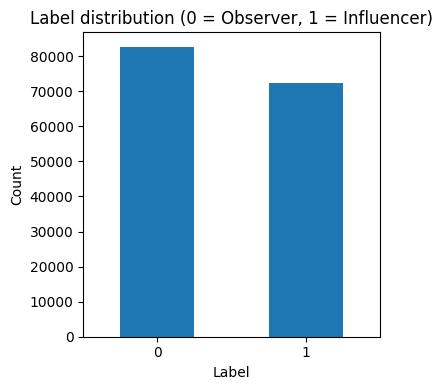

In [9]:
print("=== Label distribution (y_train) ===")
label_counts = y_train.value_counts().sort_index()
print(label_counts)

print("\nProportion per class:")
label_props = (label_counts / len(y_train)).round(3)
print(label_props)

# Bar plot of label distribution
plt.figure(figsize=(4, 4))
label_counts.plot(kind="bar")
plt.title("Label distribution (0 = Observer, 1 = Influencer)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

=== Full text length (characters) ===
count    154914.000000
mean        151.010651
std          89.982192
min           4.000000
50%         135.000000
90%         280.000000
95%         297.000000
99%         320.000000
max         842.000000
Name: full_text, dtype: float64

=== Full text length (words) ===
count    154914.000000
mean         23.851905
std          14.403293
min           1.000000
50%          21.000000
90%          45.000000
95%          49.000000
99%          55.000000
max          96.000000
Name: full_text, dtype: float64


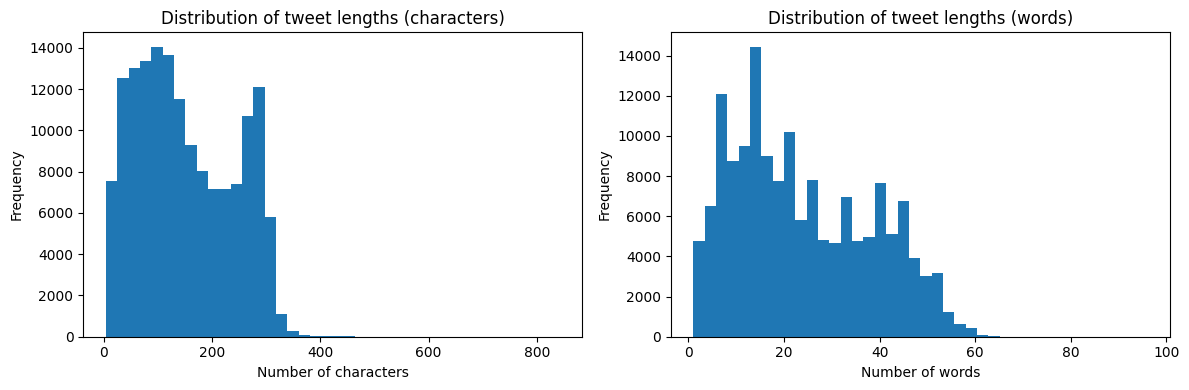

Word count at 90th percentile: 45
Word count at 95th percentile: 49
Word count at 99th percentile: 55


In [10]:
train_full_text = X_train_raw["full_text"].astype(str)

# Character lengths
char_lengths = train_full_text.str.len()

# Word lengths (split by whitespace)
word_lengths = train_full_text.str.split().str.len()

print("=== Full text length (characters) ===")
print(char_lengths.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

print("\n=== Full text length (words) ===")
print(word_lengths.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(char_lengths, bins=40)
axes[0].set_title("Distribution of tweet lengths (characters)")
axes[0].set_xlabel("Number of characters")
axes[0].set_ylabel("Frequency")

axes[1].hist(word_lengths, bins=40)
axes[1].set_title("Distribution of tweet lengths (words)")
axes[1].set_xlabel("Number of words")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print some suggested max_length candidates based on word counts
for p in [0.90, 0.95, 0.99]:
    perc_val = int(np.percentile(word_lengths, p * 100))
    print(f"Word count at {int(p*100)}th percentile: {perc_val}")

In [11]:
# Count NaNs in full_text
num_nan_full_text = X_train_raw["full_text"].isna().sum()
num_empty_full_text = (X_train_raw["full_text"].astype(str).str.strip() == "").sum()

print("Missing values in full_text (NaN):", num_nan_full_text)
print("Empty strings in full_text       :", num_empty_full_text)

# Show a few problematic rows, if any
if num_nan_full_text > 0 or num_empty_full_text > 0:
    print("\nSample rows with NaN or empty full_text:")
    problematic = X_train_raw[
        X_train_raw["full_text"].isna() |
        (X_train_raw["full_text"].astype(str).str.strip() == "")
    ]
    display(problematic.head(5))
else:
    print("\nNo NaN or empty full_text values detected in training data.")

# Do the same check quickly for Kaggle test
num_nan_full_text_k = X_kaggle_raw["full_text"].isna().sum()
num_empty_full_text_k = (X_kaggle_raw["full_text"].astype(str).str.strip() == "").sum()

print("\n[Kaggle] Missing values in full_text (NaN):", num_nan_full_text_k)
print("[Kaggle] Empty strings in full_text       :", num_empty_full_text_k)

Missing values in full_text (NaN): 0
Empty strings in full_text       : 0

No NaN or empty full_text values detected in training data.

[Kaggle] Missing values in full_text (NaN): 0
[Kaggle] Empty strings in full_text       : 0


In [12]:
if "lang" in X_train_raw.columns:
    print("=== Language distribution (train 'lang' column) ===")
    lang_counts = X_train_raw["lang"].value_counts(dropna=False)
    print(lang_counts.head(20))

    # Proportion of 'fr' if present
    if "fr" in lang_counts.index:
        frac_fr = lang_counts["fr"] / lang_counts.sum()
        print(f"\nFraction of tweets with lang='fr': {frac_fr:.3f}")
else:
    print("Column 'lang' not found in X_train_raw, skipping language EDA.")

# Optional: check lang vs label if present
if "lang" in X_train_raw.columns:
    print("\n=== Crosstab of label vs lang (top languages) ===")
    top_langs = X_train_raw["lang"].value_counts().head(5).index
    ctab = pd.crosstab(
        y_train,
        X_train_raw["lang"].where(X_train_raw["lang"].isin(top_langs), other="OTHER")
    )
    display(ctab)

=== Language distribution (train 'lang' column) ===
lang
fr    154914
Name: count, dtype: int64

Fraction of tweets with lang='fr': 1.000

=== Crosstab of label vs lang (top languages) ===


lang,fr
label,
0,82674
1,72240


=== Basic stats for structural features (all training tweets) ===


,num_hashtags,num_mentions,num_urls
count,154914.000000,154914.000000,154914.000000
mean,0.603948,0.769149,0.374576
std,1.527312,1.483013,0.594655
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000
max,31.000000,50.000000,9.000000



=== Mean counts per class ===


,num_hashtags,num_mentions,num_urls
label,,,
0,0.501270,0.972289,0.265622
1,0.721456,0.536669,0.499266


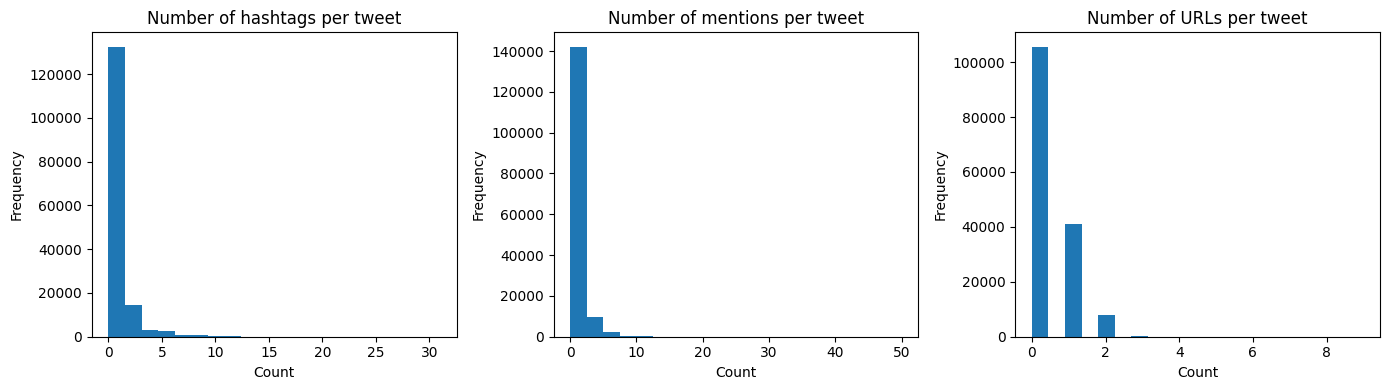

In [13]:
def count_hashtags(text: str) -> int:
    return len(re.findall(r"#\w+", text))

def count_mentions(text: str) -> int:
    return len(re.findall(r"@\w+", text))

def count_urls(text: str) -> int:
    # Very simple URL pattern
    return len(re.findall(r"http\S+|www\.\S+", text))

# Create small DataFrame with these counts for training data
struct_df = pd.DataFrame({
    "label": y_train,
    "num_hashtags": train_full_text.apply(count_hashtags),
    "num_mentions": train_full_text.apply(count_mentions),
    "num_urls": train_full_text.apply(count_urls),
})

print("=== Basic stats for structural features (all training tweets) ===")
display(struct_df[["num_hashtags", "num_mentions", "num_urls"]].describe())

print("\n=== Mean counts per class ===")
display(struct_df.groupby("label")[["num_hashtags", "num_mentions", "num_urls"]].mean())

# Quick histograms
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(struct_df["num_hashtags"], bins=20)
axes[0].set_title("Number of hashtags per tweet")

axes[1].hist(struct_df["num_mentions"], bins=20)
axes[1].set_title("Number of mentions per tweet")

axes[2].hist(struct_df["num_urls"], bins=20)
axes[2].set_title("Number of URLs per tweet")

for ax in axes:
    ax.set_xlabel("Count")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
URL_PATTERN = re.compile(r"http\S+|www\.\S+")
MENTION_PATTERN = re.compile(r"@\w+")
# We will remove the '#' but keep the hashtag word itself
HASHTAG_PATTERN = re.compile(r"#(\w+)")

def clean_tweet_text(text: str) -> str:
    """
    Light text cleaning for Transformer input.

    - Convert to string.
    - Replace URLs with 'URL'.
    - Replace mentions with '@user'.
    - Remove '#' but keep the hashtag token.
    - Collapse multiple spaces.
    """
    text = str(text)

    # Replace URLs
    text = URL_PATTERN.sub(" URL ", text)

    # Replace mentions
    text = MENTION_PATTERN.sub(" @user ", text)

    # Turn '#tag' into 'tag'
    text = HASHTAG_PATTERN.sub(r"\1", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()

# Apply cleaning to train and Kaggle full_text
X_train_raw["clean_text"] = X_train_raw["full_text"].astype(str).apply(clean_tweet_text)
X_kaggle_raw["clean_text"] = X_kaggle_raw["full_text"].astype(str).apply(clean_tweet_text)

print("Added 'clean_text' column to X_train_raw and X_kaggle_raw.")
print("X_train_raw columns now contain:", [c for c in X_train_raw.columns if 'text' in c])

# Sanity check: show a few examples before / after
print("\nSample cleaned texts (train):")
sample_indices = np.random.choice(len(X_train_raw), size=5, replace=False)
display(
    X_train_raw.loc[sample_indices, ["full_text", "clean_text"]]
)

Added 'clean_text' column to X_train_raw and X_kaggle_raw.
X_train_raw columns now contain: ['text', 'display_text_range', 'quoted_status.extended_tweet.full_text', 'quoted_status.extended_tweet.display_text_range', 'quoted_status.text', 'quoted_status.user.profile_text_color', 'user.profile_text_color', 'extended_tweet.full_text', 'extended_tweet.display_text_range', 'quoted_status.display_text_range', 'full_text', 'clean_text']

Sample cleaned texts (train):


,full_text,clean_text
106079,La preuve que la foule s'adapte aux règles d'1...,La preuve que la foule s'adapte aux règles d'1...
104990,Après ça va nous enfermer pendant tout le prin...,Après ça va nous enfermer pendant tout le prin...
120140,"Bouchez vous les oreilles, les trompettes médi...","Bouchez vous les oreilles, les trompettes médi..."
50965,"Laissons l’IHU et le Pr Raoult, soigner la Cov...","Laissons l’IHU et le Pr Raoult, soigner la Cov..."
32224,Covid-19 : un activiste emprisonné pour avoir ...,Covid-19 : un activiste emprisonné pour avoir ...


## 2. Train / validation split

We now create a validation set from the labeled training data.

Goals:

1. Split the original training set into:
   - A training split (used to optimize the model and tune hyperparameters).
   - A validation split (used to monitor performance and decide on hyperparameters).
2. Use a **stratified** split to preserve the label proportion in both splits.
3. Keep both:
   - The raw `full_text` (closest to original tweet).
   - The lightly preprocessed `clean_text` (normalized URLs, mentions, hashtags).
4. Keep references to the **full** training set (`full_text_all`, `y_all`) for a later “final training on all data” phase.

In [15]:
VAL_SIZE = 0.15

# We will split both the raw full_text and the cleaned version
X_full = X_train_raw["full_text"].astype(str)
X_clean = X_train_raw["clean_text"].astype(str)

print("Total labeled samples:", len(X_full))

(
    train_text,        # raw full_text for training
    val_text,          # raw full_text for validation
    train_text_clean,  # clean_text for training
    val_text_clean,    # clean_text for validation
    y_train_split,     # labels for training
    y_val_split,       # labels for validation
) = train_test_split(X_full, X_clean, y_train, test_size=VAL_SIZE, stratify=y_train, random_state=SEED)

print("Train split size:", len(train_text))
print("Val split size  :", len(val_text))

# Sanity check: label distribution in each split
print("\nLabel distribution (train split):")
print(y_train_split.value_counts(normalize=True).round(3))

print("\nLabel distribution (val split):")
print(y_val_split.value_counts(normalize=True).round(3))

# Peek at texts before/after cleaning
print("\nSample train_text vs train_text_clean:")
sample_idx = np.random.choice(len(train_text), size=3, replace=False)
for i, idx in enumerate(sample_idx, 1):
    raw_t = train_text.iloc[idx]
    clean_t = train_text_clean.iloc[idx]
    print(f"\nExample {i}")
    print("RAW   :", raw_t)
    print("CLEAN :", clean_t)

Total labeled samples: 154914
Train split size: 131676
Val split size  : 23238

Label distribution (train split):
label
0    0.534
1    0.466
Name: proportion, dtype: float64

Label distribution (val split):
label
0    0.534
1    0.466
Name: proportion, dtype: float64

Sample train_text vs train_text_clean:

Example 1
RAW   : @jltvar @moreau1_quentin C'est pas très covid...
CLEAN : @user @user C'est pas très covid...

Example 2
RAW   : Cher réseau, vous pouvez encore vous inscrire #Webinaire [ Zoom sur l'actualité des mesures économiques ] prévu demain de 08:30 à 09:30.
Cliquer ici pour vous inscrire : https://t.co/1FNPFw9vQW #COVID19 #aides #expertcomptable #avocats https://t.co/G1IeWNHtIB
CLEAN : Cher réseau, vous pouvez encore vous inscrire Webinaire [ Zoom sur l'actualité des mesures économiques ] prévu demain de 08:30 à 09:30. Cliquer ici pour vous inscrire : URL COVID19 aides expertcomptable avocats URL

Example 3
RAW   : Sisi venom c’est le moment d’arrêter
CLEAN : Sisi venom c’

In [16]:
# Full labeled text (raw)
full_text_all = X_train_raw["full_text"].astype(str)
# Full labeled text (cleaned)
full_text_all_clean = X_train_raw["clean_text"].astype(str)
# Full labels
y_all = y_train.copy()

print("Full dataset size:", len(full_text_all))
print("y_all shape      :", y_all.shape)

# Sanity check that proportions match the earlier global label distribution
print("\nLabel distribution (full y_all):")
print(y_all.value_counts(normalize=True).round(3))

Full dataset size: 154914
y_all shape      : (154914,)

Label distribution (full y_all):
label
0    0.534
1    0.466
Name: proportion, dtype: float64


### 3. Choosing the pretrained Transformer model

We are working with **French tweets about topics like COVID and politics**, and we need to classify users as **Influencer (1)** vs **Observer (0)**.

We consider four pretrained Transformer families:

1. **CamemBERT (`camembert-base`)**  
   - French RoBERTa style model.  
   - Trained on 138 GB of French OSCAR web corpus and Wikipedia.  
   - Strong baseline on many French NLP tasks such as POS tagging and NER. [atyun.com](https://www.atyun.com/models/info/camembert-base.html?lang=en)  

2. **Flaubert (`flaubert/flaubert-base-cased`)**  
   - French BERT style model.  
   - Trained on large French corpora, supports multiple evaluation tasks.  
   - Competitive with CamemBERT on some benchmarks. [dante.univ-tlse2.fr](https://dante.univ-tlse2.fr/access/files/original/dc5129d64b184afb03f6c773de330915dd65d18a.pdf)  

3. **Multilingual DistilBERT (`distilbert-base-multilingual-cased`)**  
   - Distilled version of multilingual BERT.  
   - Smaller and faster, supports 100+ languages including French.  
   - Good when we care about speed or memory, but usually slightly weaker than language specific models for French tasks. [metatext.io](https://metatext.io/models/distilbert-base-multilingual-cased)  

4. **Twitter XLM RoBERTa (`cardiffnlp/twitter-xlm-roberta-base`)**  
   - Based on XLM RoBERTa.  
   - Pretrained on about **198 million tweets** in eight languages, including French.  
   - Designed specifically for Twitter tasks such as sentiment and hate speech. [sparknlp.org](https://sparknlp.org/2023/07/31/sentiment_twitter_xlm_roBerta_pdc_en.html)  

Because our data are **French tweets** and the task is a tweet style classification, we want a model that is both:

- Strong on French.  
- Pretrained on Twitter data.

For this reason we choose:

> **`cardiffnlp/twitter-xlm-roberta-base`**

as our **base model**.  
It combines multilingual coverage with heavy Twitter specific pretraining on short, noisy messages similar to our challenge data. [aclanthology.org](https://aclanthology.org/2022.emnlp-demos.5.pdf)

We will:

- Use the **base language model** (`AutoModel`) from this checkpoint.  
- Add our **own classification head** on top, with pooling and a small MLP.  

This custom head gives us more control over pooling and regularization. This can give slightly better accuracy than the default single linear head over the CLS token, especially on small to medium sized datasets.

In [17]:
# Chosen Twitter oriented multilingual model with good support for French tweets
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base"

# Documentation of alternative models we considered
CANDIDATE_MODELS = {
    "camembert_base": "camembert-base",
    "flaubert_base_cased": "flaubert/flaubert-base-cased",
    "distilbert_multilingual": "distilbert-base-multilingual-cased",
    "twitter_xlm_roberta_base": "cardiffnlp/twitter-xlm-roberta-base",
}

# Number of labels in our task: Influencer (1) vs Observer (0)
NUM_LABELS = 2

print("Using pretrained model:", MODEL_NAME)
print("Number of labels:", NUM_LABELS)

Using pretrained model: cardiffnlp/twitter-xlm-roberta-base
Number of labels: 2


In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

print("Tokenizer loaded.")
print("Tokenizer class:", type(tokenizer))
print("Special tokens:")
print("  - pad_token:", tokenizer.pad_token, "id:", tokenizer.pad_token_id)
print("  - cls token:", tokenizer.cls_token, "id:", tokenizer.cls_token_id)
print("  - sep token:", tokenizer.sep_token, "id:", tokenizer.sep_token_id)

Tokenizer loaded.
Tokenizer class: <class 'transformers.models.xlm_roberta.tokenization_xlm_roberta_fast.XLMRobertaTokenizerFast'>
Special tokens:
  - pad_token: <pad> id: 1
  - cls token: <s> id: 0
  - sep token: </s> id: 2


In [19]:
# Maximum sequence length for tokenization
MAX_LENGTH = 256

print("MAX_LENGTH set to:", MAX_LENGTH)

MAX_LENGTH set to: 256


In [20]:
# Load base Transformer with no classification head yet
base_model = AutoModel.from_pretrained(MODEL_NAME)

# Move to the same device as before
base_model.to(device)

# Print a short summary
print("Base model loaded.")
print("Model type:", type(base_model))
print("Hidden size:", base_model.config.hidden_size)
print("Number of layers:", base_model.config.num_hidden_layers)
print("Vocab size:", base_model.config.vocab_size)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model loaded.
Model type: <class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaModel'>
Hidden size: 768
Number of layers: 12
Vocab size: 250002


### 4. Dataset and DataLoaders

In [21]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels = None, tokenizer = None, max_length = 256):
        """
        texts     : iterable of tweet strings
        labels    : iterable of int labels (0/1) or None for test/Kaggle data
        tokenizer : HuggingFace tokenizer
        max_length: max token length for padding/truncation
        """
        self.texts = list(texts)
        self.labels = None if labels is None else list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Get text
        text = self.texts[idx]

        # Tokenize
        encoded = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        ) # type: ignore

        # encoded["input_ids"]: (1, max_length)
        # encoded["attention_mask"]: (1, max_length)
        item = {
            "input_ids": encoded["input_ids"].squeeze(0),        # (max_length,)
            "attention_mask": encoded["attention_mask"].squeeze(0),  # (max_length,)
        }

        # Add label if available
        if self.has_labels:
            label = self.labels[idx] # type: ignore
            item["labels"] = torch.tensor(label, dtype=torch.long)

        return item

In [22]:
# Quick sanity check for the dataset class
tmp_dataset = TweetDataset(
    texts=train_text_clean.iloc[:5],
    labels=y_train_split.iloc[:5],
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)

print("Length of tmp_dataset:", len(tmp_dataset))
sample_item = tmp_dataset[0]
for k, v in sample_item.items():
    print(k, v.shape, v.dtype)

Length of tmp_dataset: 5
input_ids torch.Size([256]) torch.int64
attention_mask torch.Size([256]) torch.int64
labels torch.Size([]) torch.int64


In [23]:
# Train dataset (using cleaned text)
train_dataset = TweetDataset(
    texts=train_text_clean,
    labels=y_train_split,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)

# Validation dataset (using cleaned text)
val_dataset = TweetDataset(
    texts=val_text_clean,
    labels=y_val_split,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)

# Kaggle / test dataset (no labels)
kaggle_dataset = TweetDataset(
    texts=X_kaggle_raw["full_text"],
    labels=None,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)

print("Train dataset size   :", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Kaggle dataset size    :", len(kaggle_dataset))

Train dataset size   : 131676
Validation dataset size: 23238
Kaggle dataset size    : 103380


In [24]:
BATCH_SIZE = 32   # adjustable
NUM_WORKERS = 0   # can be set to 0 if we see DataLoader issues

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

kaggle_loader = DataLoader(
    kaggle_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print("DataLoaders created.")
print("  - train batches :", len(train_loader))
print("  - val batches   :", len(val_loader))
print("  - kaggle batches:", len(kaggle_loader))

DataLoaders created.
  - train batches : 4115
  - val batches   : 727
  - kaggle batches: 3231


In [25]:
# Inspect one batch from train_loader
batch = next(iter(train_loader))

print("Batch keys:", batch.keys())
print("input_ids shape     :", batch["input_ids"].shape)
print("attention_mask shape:", batch["attention_mask"].shape)
print("labels shape        :", batch["labels"].shape)
print("Example labels      :", batch["labels"][:10])

Batch keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
input_ids shape     : torch.Size([32, 256])
attention_mask shape: torch.Size([32, 256])
labels shape        : torch.Size([32])
Example labels      : tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1])


### 5. XLM-R tweet classifier: base encoder + classification head

We now build a classification model that uses the "base + head" design:

- **Base encoder**: `AutoModel.from_pretrained(MODEL_NAME)`  
  This outputs contextual token embeddings.

- **Pooling**:
  - The encoder returns `last_hidden_state` of shape `(batch_size, seq_len, hidden_size)`.
  - We apply **mean pooling** over the non-padded tokens:
    - We use `attention_mask` to ignore `[PAD]` positions.
    - This gives one vector per tweet of shape `(batch_size, hidden_size)`.

- **Classification head**:
  - A dropout layer (regularization).
  - A linear layer `hidden_size → 2` to output logits for:
    - class 0: Observer
    - class 1: Influencer

In [26]:
def mean_pooling(last_hidden_state, attention_mask):
    """
    last_hidden_state: (batch_size, seq_len, hidden_size)
    attention_mask   : (batch_size, seq_len) with 1 for real tokens and 0 for padding

    Returns:
        pooled: (batch_size, hidden_size)
    """
    # Expand attention_mask to match hidden size
    # shape: (batch_size, seq_len, 1) -> (batch_size, seq_len, hidden_size)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()

    # Zero out padded token embeddings, then sum over tokens
    sum_embeddings = (last_hidden_state * input_mask_expanded).sum(dim=1)

    # Count how many tokens are not padding in each sequence
    sum_mask = input_mask_expanded.sum(dim=1)  # (batch_size, hidden_size)

    # Avoid division by zero
    sum_mask = torch.clamp(sum_mask, min=1e-9)

    # Mean pooling
    return sum_embeddings / sum_mask

In [27]:
# Sanity check for mean_pooling
batch_size, seq_len, hidden_size = 2, 4, 3
dummy_hidden = torch.ones((batch_size, seq_len, hidden_size))
dummy_mask = torch.tensor([[1, 1, 0, 0],
                           [1, 1, 1, 0]])
pooled = mean_pooling(dummy_hidden, dummy_mask)
print("Pooled shape:", pooled.shape)  # should be (2, 3)
print("Pooled values:", pooled)       # just to check it runs

Pooled shape: torch.Size([2, 3])
Pooled values: tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [28]:
class TweetClassifier(nn.Module):
    def __init__(self, base_model, dropout_prob=0.1, num_labels=2):
        super().__init__()
        self.base_model = base_model  # XLM-R base encoder
        hidden_size = base_model.config.hidden_size

        self.dropout = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        """
        input_ids     : (batch_size, seq_len)
        attention_mask: (batch_size, seq_len)

        Returns:
            logits: (batch_size, num_labels)
        """
        # Base model forward; HuggingFace models return a BaseModelOutput
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        # last_hidden_state: (batch_size, seq_len, hidden_size)
        last_hidden_state = outputs.last_hidden_state

        # Mean pooling over non-padded tokens
        pooled = mean_pooling(last_hidden_state, attention_mask)  # (batch_size, hidden_size)

        # Dropout + linear classifier
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)  # (batch_size, num_labels)

        return logits

In [29]:
# Instantiate classifier
tweet_model = TweetClassifier(
    base_model = base_model,
    dropout_prob = 0.1,
    num_labels = 2,
)

tweet_model.to(device)

# Print a small summary
print(tweet_model)

TweetClassifier(
  (base_model): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
 

In [30]:
# Sanity check: run one batch through the model
tweet_model.eval()

batch = next(iter(train_loader))
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
labels = batch["labels"].to(device)

with torch.no_grad():
    logits = tweet_model(input_ids=input_ids, attention_mask=attention_mask)

print("Input_ids shape    :", input_ids.shape)
print("Attention_mask shape:", attention_mask.shape)
print("Logits shape       :", logits.shape)
print("Labels shape       :", labels.shape)

Input_ids shape    : torch.Size([32, 256])
Attention_mask shape: torch.Size([32, 256])
Logits shape       : torch.Size([32, 2])
Labels shape       : torch.Size([32])


In [31]:
# Optional utilities to freeze / unfreeze the encoder

def freeze_base_encoder(model):
    """
    Freeze all parameters of the base encoder; only classification head remains trainable.
    """
    for param in model.base_model.parameters():
        param.requires_grad = False

def unfreeze_base_encoder(model):
    """
    Unfreeze all parameters of the base encoder.
    """
    for param in model.base_model.parameters():
        param.requires_grad = True

In [32]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in tweet_model.parameters() if p.requires_grad)
all_params       = sum(p.numel() for p in tweet_model.parameters())
print(f"Trainable parameters: {trainable_params:,}/{all_params:,}")

Trainable parameters: 278,045,186/278,045,186


## 6. Training configuration: loss, optimizer, scheduler

In this section we set up:

- Loss: Cross entropy (for 2 classes: 0 = Observer, 1 = Influencer).
- Optimizer: AdamW with weight decay.
- Learning-rate schedule: optional linear warmup + linear decay.

**Current hyperparameters**

- `num_epochs` = 3  (we can increase later to 4–5 if training is stable)
- `batch_size` = 32 (Set in step 4)
- `learning_rate` = 2e-5
- `weight_decay` = 0.01
- `max_length` = 256
- `dropout` in classification head = 0.1
- `warmup_ratio` = 0.1 (10% of steps for warmup)

We can later tune these (learning rate, epochs, max_length) and compare runs.

In [33]:
NUM_EPOCHS = 3          # starting point; can increase later
LEARNING_RATE = 2e-5    # typical for base-sized Transformers
WEIGHT_DECAY = 0.01     # standard for BERT-like models
WARMUP_RATIO = 0.1      # 10% of steps for warmup

print(f"Training for {NUM_EPOCHS} epochs with lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY}")

Training for 3 epochs with lr=2e-05, weight_decay=0.01


In [34]:
criterion = nn.CrossEntropyLoss()

print(criterion)

CrossEntropyLoss()


In [35]:
# Names that should NOT receive weight decay (bias and LayerNorm)
no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]

optimizer_grouped_parameters = [
    {
        "params": [
            p for n, p in tweet_model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": WEIGHT_DECAY,
    },
    {
        "params": [
            p for n, p in tweet_model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=LEARNING_RATE,
)

print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.01

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.0
)


In [36]:
# Total number of training steps = batches per epoch * number of epochs
num_training_steps = len(train_loader) * NUM_EPOCHS
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)

print(f"Total training steps: {num_training_steps}")
print(f"Warmup steps (approx {WARMUP_RATIO*100:.1f}%): {num_warmup_steps}")

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

scheduler

Total training steps: 12345
Warmup steps (approx 10.0%): 1234


## 7. Training loop (classification only)

We now implement:

- `train_one_epoch` for one full pass over the training set.
- `evaluate` for validation loss and accuracy.
- A high-level epoch loop that:
  - Trains for `NUM_EPOCHS`.
  - Tracks the best validation accuracy.
  - Saves the best model to `OUTPUT_DIR`.
  - Logs histories of loss and accuracy, and plots them at the end.

In [37]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler=None, max_grad_norm=1.0):
    """
    Train the model for one epoch on the training set.

    Returns
    -------
    avg_loss : float
        Average training loss over the epoch.
    avg_acc : float
        Average training accuracy over the epoch.
    """
    model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # nice progress bar over batches
    pbar = tqdm(train_loader, desc="Training", leave=False)

    for batch in pbar:
        # batch should be a dict from our TweetDataset:
        # {
        #   "input_ids": ...,
        #   "attention_mask": ...,
        #   "labels": ...
        # }

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # 1. Zero previous gradients
        optimizer.zero_grad()

        # 2. Forward pass
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        # logits: (batch_size, 2)

        # 3. Compute loss
        loss = criterion(logits, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Optional gradient clipping
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # 6. Optimizer step
        optimizer.step()

        # 7. Scheduler step (if given)
        if scheduler is not None:
            scheduler.step()

        # 8. Update running stats
        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size

        # predictions: argmax over class dimension
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += batch_size

        # Update progress bar info
        current_loss = running_loss / max(running_total, 1)
        current_acc = running_correct / max(running_total, 1)
        pbar.set_postfix(
            loss=f"{current_loss:.4f}",
            acc=f"{current_acc:.4f}",
        )

    avg_loss = running_loss / running_total
    avg_acc = running_correct / running_total

    return avg_loss, avg_acc

In [38]:
def evaluate(model, val_loader, criterion, device):
    """
    Evaluate the model on the validation set.

    Returns
    -------
    avg_loss : float
        Average validation loss.
    avg_acc : float
        Validation accuracy.
    """
    model.eval()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation", leave=False)

        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass only
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            loss = criterion(logits, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size

            preds = torch.argmax(logits, dim=1)
            running_correct += (preds == labels).sum().item()
            running_total += batch_size

            current_loss = running_loss / max(running_total, 1)
            current_acc = running_correct / max(running_total, 1)
            pbar.set_postfix(
                loss=f"{current_loss:.4f}",
                acc=f"{current_acc:.4f}",
            )

    avg_loss = running_loss / running_total
    avg_acc = running_correct / running_total

    return avg_loss, avg_acc

In [39]:
LOAD_FROM_CHECKPOINT = True # Set to False to force training from scratch

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
best_epoch = 0
start_epoch = 1

save_path = os.path.join(OUTPUT_DIR, "best_model.pt")
print(f"Model checkpoints will be saved to / loaded from: {save_path}")

# Load existing checkpoint
if LOAD_FROM_CHECKPOINT and os.path.exists(save_path):
    print("\nFound existing checkpoint. Loading it...")
    checkpoint = torch.load(save_path, map_location=device)

    # Load model weights
    tweet_model.load_state_dict(checkpoint["model_state_dict"])

    # Restore best validation accuracy and epoch if present
    best_val_acc = checkpoint.get("best_val_acc", 0.0)
    best_epoch = checkpoint.get("epoch", 0)
    start_epoch = best_epoch + 1

    # Restore optimizer and scheduler
    if "optimizer_state_dict" in checkpoint:
        try:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            print(" Optimizer state restored.")
        except Exception as e:
            print(" Cold not restore optimizer state:", e)
    
    if "scheduler_state_dict" in checkpoint and checkpoint["scheduler_state_dict"] is not None:
        try:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
            print(" Scheduler state restored.")
        except Exception as e:
            print(" Could not restore scheduler state:", e)
        
    print(f"Restored model from epoch {best_epoch} with best_val_acc = {best_val_acc:.4f}")
else:
    print("\nNo checkpoint loaded. Starting from scratch.")

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{NUM_EPOCHS} =====")

    # Train one epoch
    train_loss, train_acc = train_one_epoch(
        model=tweet_model,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        scheduler=scheduler,
        max_grad_norm=1.0,
    )

    # Evaluate on validation set 
    val_loss, val_acc = evaluate(
        model=tweet_model,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
    )

    # Log history 
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d} - "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

    # Save best model 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

        # Save the model weights (state_dict)
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": tweet_model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
                "best_val_acc": best_val_acc,
            },
            save_path,
        )
        print(f"  --> New best model saved (val_acc = {best_val_acc:.4f})")

print(f"\nTraining finished. Best val_acc = {best_val_acc:.4f} at epoch {best_epoch}.")

Model checkpoints will be saved to / loaded from: /Users/zeen/Projects/social-dl/outputs/distilbert/best_model.pt

Found existing checkpoint. Loading it...
Restored model from epoch 3 with best_val_acc = 0.6973

Training finished. Best val_acc = 0.6973 at epoch 3.


ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

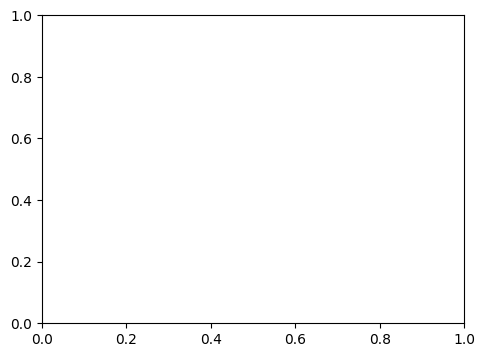

In [40]:
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train loss")
plt.plot(epochs_range, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train acc")
plt.plot(epochs_range, val_accuracies, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()